In [28]:
import json

import sentence_transformers
import torch
import numpy as np
from sentence_transformers.quantization import quantize_embeddings
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [29]:
# Load the model
model = sentence_transformers.SentenceTransformer(
    'jordyvl/scibert_scivocab_uncased_sentence_transformer',
    device='mps'
)


/Users/vincie/miniconda3/envs/master/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [30]:
with open('../data/datasets/IND-WhoIsWho/pid_to_info_all.json', 'r') as f:
    data = json.loads(f.read())

titles = []
abstracts = []
for key, val in data.items():
    if val['title']:
        titles.append(val['title'].lower())
    if val['abstract']:
        abstracts.append(val['abstract'].lower())

print(titles[:5])

['probabilistic skyline operator over sliding windows', 'editorial: knowledge-driven activity recognition in intelligent environments', 'subscriber assignment for wide-area content-based publish/subscribe', 'tree-based mining for discovering patterns of human interaction in meetings', 'protein function prediction using multi-label ensemble classification']


## Embedding similarity comparison

Correlation between Hamming distance matrix and Cosine distance matrix: 0.8138


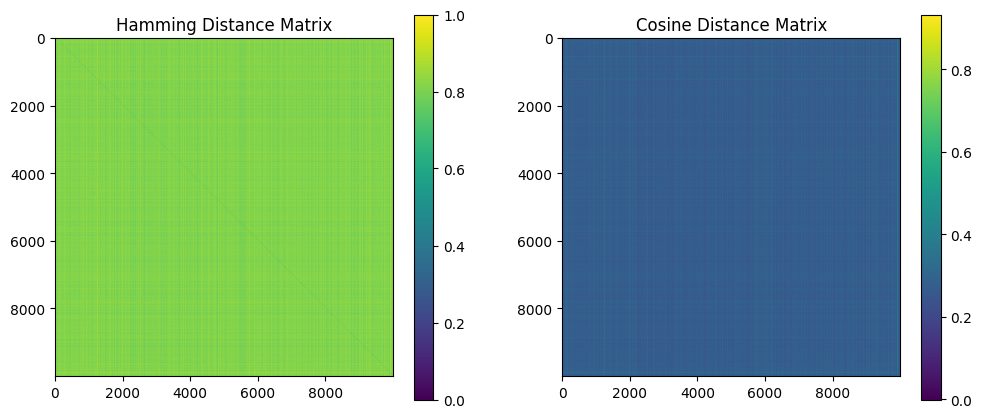

In [36]:
# Encode the titles
num_entries = 10000
embeddings = model.encode(abstracts[:num_entries])

cos_sim = cosine_similarity(embeddings)

emb_quantized = quantize_embeddings(embeddings, precision='ubinary')

# Compute hamming distance matrix
hamming_dist_matrix = squareform(pdist(emb_quantized, metric='hamming'))

cosine_dist_matrix = 1 - cos_sim

hamming_dist_matrix_normalized = hamming_dist_matrix / np.max(hamming_dist_matrix)
cosine_dist_matrix_normalized = cosine_dist_matrix / np.max(cosine_dist_matrix)

# Compare the matrices
correlation = np.corrcoef(hamming_dist_matrix_normalized.flatten(), cosine_dist_matrix_normalized.flatten())[0, 1]
print(f'Correlation between Hamming distance matrix and Cosine distance matrix: {correlation:.4f}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(hamming_dist_matrix, cmap='viridis')
plt.title('Hamming Distance Matrix')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(cosine_dist_matrix, cmap='viridis')
plt.title('Cosine Distance Matrix')
plt.colorbar()

plt.show()


## Ranking comparison

In [37]:
from scipy.stats import spearmanr

spearman_corrs = []

for i in range(num_entries):
    cosine_rank = np.argsort(cosine_dist_matrix_normalized[i])
    hamming_rank = np.argsort(hamming_dist_matrix_normalized[i])

    spearman_corr, _ = spearmanr(cosine_rank, hamming_rank)
    spearman_corrs.append(spearman_corr)

# Calculate average spearman rank correlation
avg_spearman_corr = np.mean(spearman_corrs)

print(f'Average Spearman Rank Correlation: {avg_spearman_corr:.4f}')

Average Spearman Rank Correlation: 0.0007


In [38]:
top_n = 50

# Initialize list to store consistency results
consistency_counts = []

for i in range(num_entries):
    # Get the top-N indices for normal embeddings
    top_n_cosine = np.argsort(cosine_dist_matrix_normalized[i])[:top_n]
    
    # Get the top-N indices for quantized embeddings
    top_n_hamming = np.argsort(hamming_dist_matrix[i])[:top_n]
    
    # Calculate intersection (common elements) between the two top-N lists
    intersection = len(set(top_n_cosine).intersection(set(top_n_hamming)))
    
    # Store the number of common elements
    consistency_counts.append(intersection)

# Calculate the average consistency across all queries
average_consistency = np.mean(consistency_counts)
print(f'Average Top-{top_n} Consistency: {average_consistency:.2f} out of {top_n}')

Average Top-50 Consistency: 22.98 out of 50
